In [1]:
print("hello")

hello


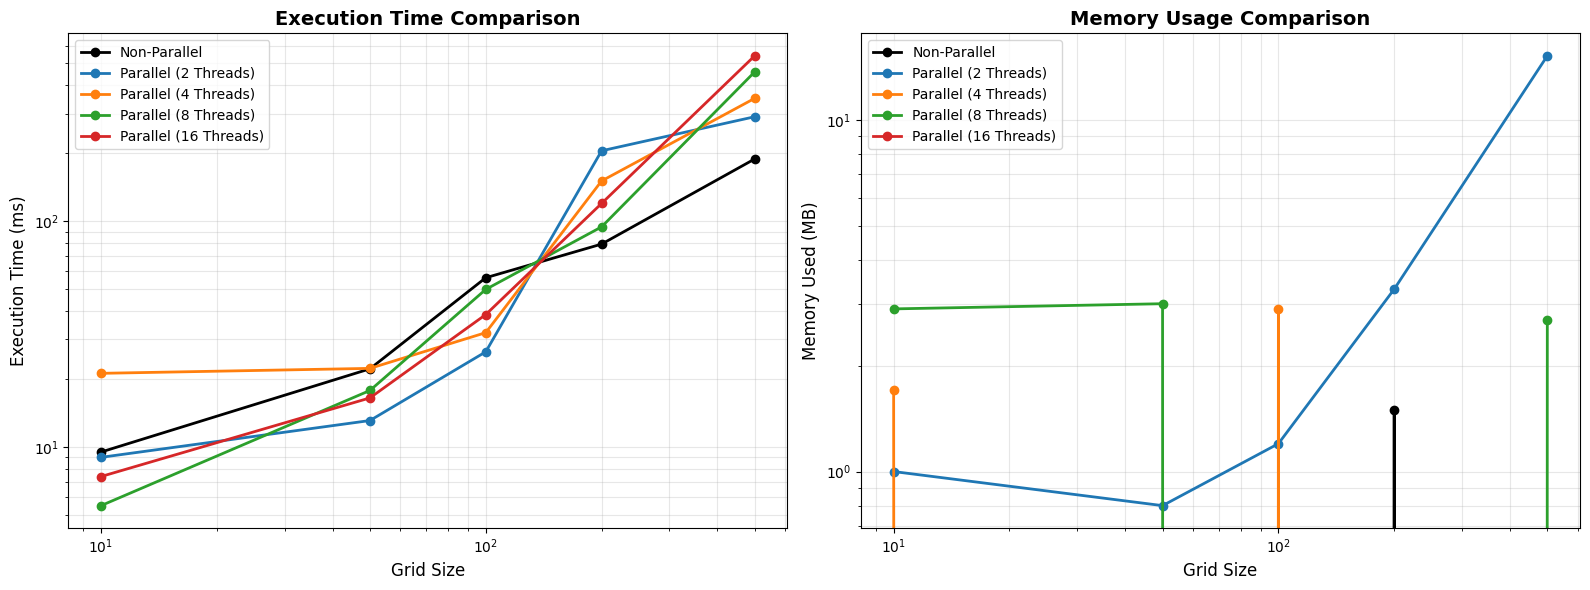

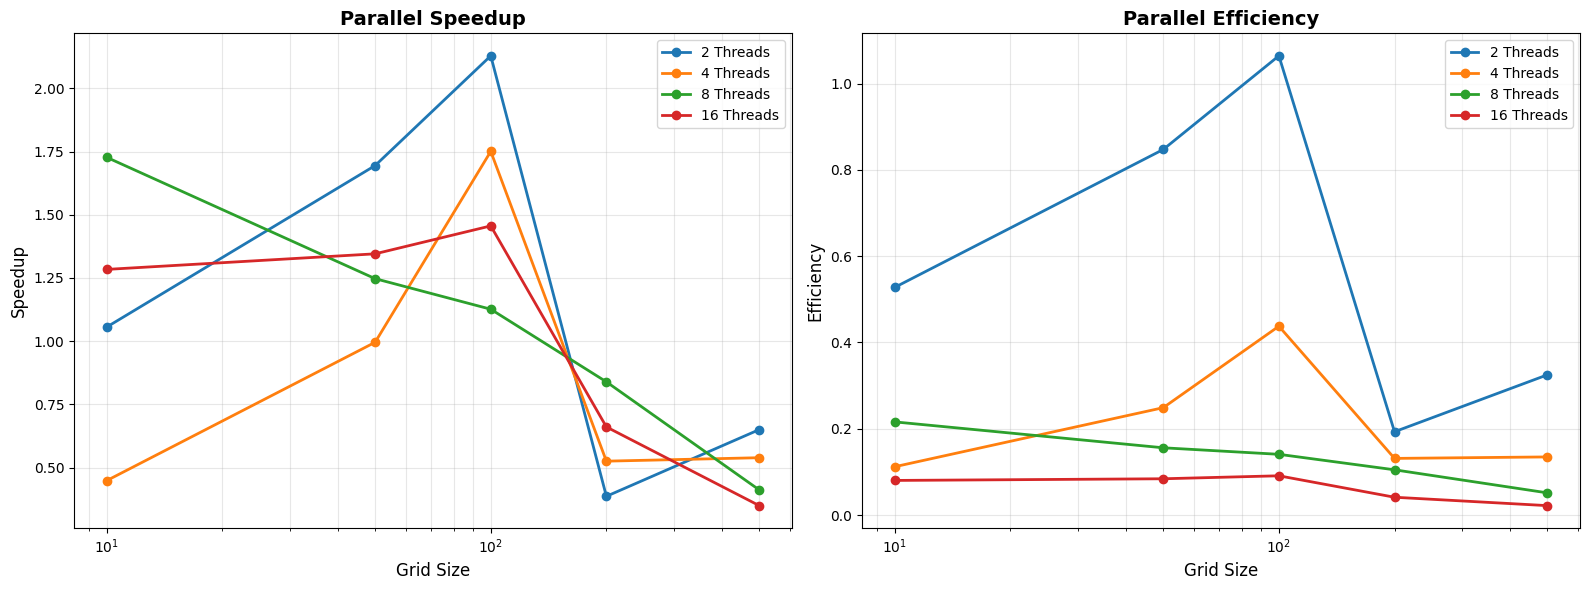

Non-Parallel Performance Summary:
   Grid Size  Avg Execution Time  Std Execution Time  Avg Memory Used  \
0         10                 9.5            6.980131              0.0   
1         50                22.2           11.173381              0.0   
2        100                56.2           54.478946             -0.2   
3        200                79.2           46.014008              1.5   
4        500               188.7           64.067759             -3.6   

   Std Memory Used  
0         0.000000  
1         0.000000  
2         3.966527  
3         7.199537  
4        30.591212  

Parallel Performance Summary:
    Grid Size  Number of Threads  Avg Execution Time  Std Execution Time  \
0          10                  2                 9.0            7.287737   
1          10                  4                21.2           34.282487   
2          10                  8                 5.5            1.433721   
3          10                 16                 7.4            3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV files
def load_performance_data():
    try:
        non_parallel_df = pd.read_csv('non_parallel_performance.csv')
        parallel_df = pd.read_csv('parallel_performance.csv')
        return non_parallel_df, parallel_df
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Ensure CSV files are in the same directory as the notebook")
        return None, None

# Aggregate performance data
def aggregate_performance_data(df):
    if df is None:
        return None
    
    # For non-parallel data
    if 'Number of Threads' not in df.columns:
        aggregated = df.groupby('Grid Size').agg({
            'Execution Time (ms)': ['mean', 'std'],
            'Memory Used (MB)': ['mean', 'std']
        }).reset_index()
        aggregated.columns = ['Grid Size', 'Avg Execution Time', 'Std Execution Time', 
                               'Avg Memory Used', 'Std Memory Used']
    # For parallel data
    else:
        aggregated = df.groupby(['Grid Size', 'Number of Threads']).agg({
            'Execution Time (ms)': ['mean', 'std'],
            'Memory Used (MB)': ['mean', 'std']
        }).reset_index()
        aggregated.columns = ['Grid Size', 'Number of Threads', 
                               'Avg Execution Time', 'Std Execution Time', 
                               'Avg Memory Used', 'Std Memory Used']
    
    return aggregated

# Visualization functions
def plot_performance_comparison(non_parallel_agg, parallel_agg):
    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))
    
    # Color palette with more distinct colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Execution Time Comparison
    plt.subplot(1, 2, 1)
    plt.plot(non_parallel_agg['Grid Size'], 
             non_parallel_agg['Avg Execution Time'], 
             marker='o', color='black', label='Non-Parallel', linewidth=2)
    
    # Plot different thread counts for parallel
    if parallel_agg is not None:
        thread_counts = parallel_agg['Number of Threads'].unique()
        for i, thread_count in enumerate(thread_counts):
            parallel_thread_data = parallel_agg[parallel_agg['Number of Threads'] == thread_count]
            plt.plot(parallel_thread_data['Grid Size'], 
                     parallel_thread_data['Avg Execution Time'], 
                     marker='o', label=f'Parallel ({thread_count} Threads)', 
                     color=colors[i % len(colors)], linewidth=2)
    
    plt.title('Execution Time Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Grid Size', fontsize=12)
    plt.ylabel('Execution Time (ms)', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.grid(True, which="both", ls="-", alpha=0.3)
    
    # Memory Usage Comparison
    plt.subplot(1, 2, 2)
    plt.plot(non_parallel_agg['Grid Size'], 
             non_parallel_agg['Avg Memory Used'], 
             marker='o', color='black', label='Non-Parallel', linewidth=2)
    
    if parallel_agg is not None:
        for i, thread_count in enumerate(thread_counts):
            parallel_thread_data = parallel_agg[parallel_agg['Number of Threads'] == thread_count]
            plt.plot(parallel_thread_data['Grid Size'], 
                     parallel_thread_data['Avg Memory Used'], 
                     marker='o', label=f'Parallel ({thread_count} Threads)', 
                     color=colors[i % len(colors)], linewidth=2)
    
    plt.title('Memory Usage Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Grid Size', fontsize=12)
    plt.ylabel('Memory Used (MB)', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.grid(True, which="both", ls="-", alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Speedup Analysis
def calculate_speedup(non_parallel_agg, parallel_agg):
    if non_parallel_agg is None or parallel_agg is None:
        return None
    
    speedup_data = []
    
    # Get unique grid sizes
    grid_sizes = non_parallel_agg['Grid Size'].unique()
    
    for grid_size in grid_sizes:
        # Get non-parallel execution time for this grid size
        non_parallel_time = non_parallel_agg[non_parallel_agg['Grid Size'] == grid_size]['Avg Execution Time'].values[0]
        
        # Calculate speedup for each thread count
        thread_counts = parallel_agg['Number of Threads'].unique()
        for thread_count in thread_counts:
            # Get parallel execution time for this grid size and thread count
            parallel_time_row = parallel_agg[(parallel_agg['Grid Size'] == grid_size) & 
                                             (parallel_agg['Number of Threads'] == thread_count)]
            
            if not parallel_time_row.empty:
                parallel_time = parallel_time_row['Avg Execution Time'].values[0]
                
                # Calculate speedup and efficiency
                speedup = non_parallel_time / parallel_time if parallel_time > 0 else 1
                efficiency = speedup / thread_count
                
                speedup_data.append({
                    'Grid Size': grid_size,
                    'Threads': thread_count,
                    'Speedup': speedup,
                    'Efficiency': efficiency
                })
    
    return pd.DataFrame(speedup_data)

# Parallel Efficiency Visualization
def plot_parallel_performance(speedup_df):
    if speedup_df is None:
        print("No speedup data available")
        return
    
    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))
    
    # Color palette with more distinct colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Speedup Plot
    plt.subplot(1, 2, 1)
    thread_counts = speedup_df['Threads'].unique()
    for i, thread_count in enumerate(thread_counts):
        thread_data = speedup_df[speedup_df['Threads'] == thread_count]
        plt.plot(thread_data['Grid Size'], thread_data['Speedup'], 
                 marker='o', label=f'{thread_count} Threads', 
                 color=colors[i % len(colors)], linewidth=2)
    
    plt.title('Parallel Speedup', fontsize=14, fontweight='bold')
    plt.xlabel('Grid Size', fontsize=12)
    plt.ylabel('Speedup', fontsize=12)
    plt.xscale('log')
    plt.legend(fontsize=10)
    plt.grid(True, which="both", ls="-", alpha=0.3)
    
    # Efficiency Plot
    plt.subplot(1, 2, 2)
    for i, thread_count in enumerate(thread_counts):
        thread_data = speedup_df[speedup_df['Threads'] == thread_count]
        plt.plot(thread_data['Grid Size'], thread_data['Efficiency'], 
                 marker='o', label=f'{thread_count} Threads', 
                 color=colors[i % len(colors)], linewidth=2)
    
    plt.title('Parallel Efficiency', fontsize=14, fontweight='bold')
    plt.xlabel('Grid Size', fontsize=12)
    plt.ylabel('Efficiency', fontsize=12)
    plt.xscale('log')
    plt.legend(fontsize=10)
    plt.grid(True, which="both", ls="-", alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def perform_comprehensive_analysis():
    # Load data
    non_parallel_df, parallel_df = load_performance_data()
    
    if non_parallel_df is None or parallel_df is None:
        print("Failed to load performance data")
        return
    
    # Aggregate data
    non_parallel_agg = aggregate_performance_data(non_parallel_df)
    parallel_agg = aggregate_performance_data(parallel_df)
    
    # Performance Comparison Visualization
    plot_performance_comparison(non_parallel_agg, parallel_agg)
    
    # Speedup and Efficiency Analysis
    speedup_df = calculate_speedup(non_parallel_agg, parallel_agg)
    plot_parallel_performance(speedup_df)
    
    # Statistical Summary
    print("Non-Parallel Performance Summary:")
    print(non_parallel_agg)
    print("\nParallel Performance Summary:")
    print(parallel_agg)
    print("\nSpeedup and Efficiency Summary:")
    print(speedup_df)

# Run the analysis
perform_comprehensive_analysis()